### Packeges and Libraries

In [ ]:
# Choose available CUDAs for parallell computing
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,2,5"

print("This notebook's PID:", os.getpid())

This notebook's PID: 2842250


In [ ]:
import numpy as np
import pandas as pd
import glob

import rasterio
from rasterio.transform import from_origin

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from skimage.transform import resize
from skimage import exposure

from tqdm import tqdm

from concurrent.futures import ThreadPoolExecutor

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import vgg16_bn, VGG16_BN_Weights

from sklearn.metrics import f1_score
from torch.amp import autocast, GradScaler

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Import CNN models
import import_ipynb
from models import HyperspectralTransferCNN, ImprovedHybrid3D2DCNN_v2, ImprovedHybrid3D2DCNN_v3, VGG16WithAttention, VGG16WithCBAM

In [ ]:
if torch.cuda.device_count() > 1:
    print(f"🖥️ Using {torch.cuda.device_count()} GPUs with DataParallel")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current device: {device}.")

🖥️ Using 3 GPUs with DataParallel


### Paths

In [ ]:

# Faubai data paths
folder_path = "/home/_shared/ARIEL/Faubai/"
test_folder_path = '/home/_shared/ARIEL/Faubai/TEST'
he5_directory = "/home/_shared/ARIEL/Faubai/datalake"
labels_path = '/home/salyken/PRISMA/PRISMA_data/labels_csv'
xlsx_path = os.path.join(folder_path, '2023_02_22_Faubai_dataset_v1.xlsx')

# save_dir_chunks = '/home/salyken/PRISMA/PRISMA_data/PRISMA_dataset_processed/chuncked_dataset' # 5x5 pixel patches
save_dir_chunks = '/home/salyken/PRISMA/PRISMA_data/PRISMA_dataset_processed/chuncked_dataset_patch_size_71' # 71x71 pixel patches

### Investigate Faubai Files

In [ ]:
def file_identifier(file_path): 

        # file_path = os.path.join(folder_path, file)
        
        if file_path.endswith(".xlsx"):
            df = pd.read_excel(file_path, engine="openpyxl")
            print(f"Opened Excel file: {file_path}")
            return df
    
        elif file_path.endswith(".tif"):
            with rasterio.open(file_path) as src:
                print(f"Opened TIFF file: {file_path}, Shape:", src.read(3).shape)
                img = src.read(1)  # Read the first band (1-based index)
                
            # Display the image
            plt.imshow(img, cmap="gray")
            plt.colorbar()
            plt.title("GeoTIFF - Single Band")
            plt.xlabel("Width (X)")
            plt.ylabel("Height (Y)")
            plt.show()

    
        elif file_path.endswith(".mat"):
            mat_data = loadmat(file_path)
            print(f"Opened MAT file: {file_path}, Keys:", mat_data.keys())
    
        else:
            print(f"Skipping unknown file: {file_path}")

xlxs_ex = os.path.join(folder_path, '2023_02_22_Faubai_dataset_v1.xlsx')
updated_list = os.path.join(folder_path, 'updated_list.xlsx') 
# tif_ex = os.path.join(folder_path, 'TEST', 'PRS_L1_STD_OFFL_20200525105010_20200525105014_0001.tif')
                       

df_excel = file_identifier(xlxs_ex)
df_updated_list = file_identifier(updated_list)
# tif_data = file_identifier(tif_ex)


Opened Excel file: /home/_shared/ARIEL/Faubai/2023_02_22_Faubai_dataset_v1.xlsx
Opened Excel file: /home/_shared/ARIEL/Faubai/updated_list.xlsx


In [ ]:
df_excel.head()

,datetime,lat,lon,regions,countries,name,pine,spruce,deciduous,water,cloudsnow,Train,Validation,Test
0,1970-01-01 01:00:44,63.175179,9.014432,"Tr, M",N,PRS_L1_STD_OFFL_20200421110225_20200421110229_...,31127,23435,36827,29112,855125,NaN,NaN,X
1,1970-01-01 01:00:44,62.923306,8.816792,"Tr, M",N,PRS_L1_STD_OFFL_20200421110229_20200421110233_...,21222,30464,42153,65441,801955,X,NaN,NaN
2,1970-01-01 01:00:44,62.671070,8.621074,M,N,PRS_L1_STD_OFFL_20200421110233_20200421110238_...,14211,10789,47329,52463,849585,X,NaN,NaN
3,1970-01-01 01:00:44,62.417690,8.427835,"M, I",N,PRS_L1_STD_OFFL_20200421110238_20200421110242_...,1021,269,6931,4019,984125,X,NaN,NaN
4,1970-01-01 01:00:44,62.163586,8.236990,"M, I",N,PRS_L1_STD_OFFL_20200421110242_20200421110246_...,258,327,364,40,998934,NaN,X,NaN


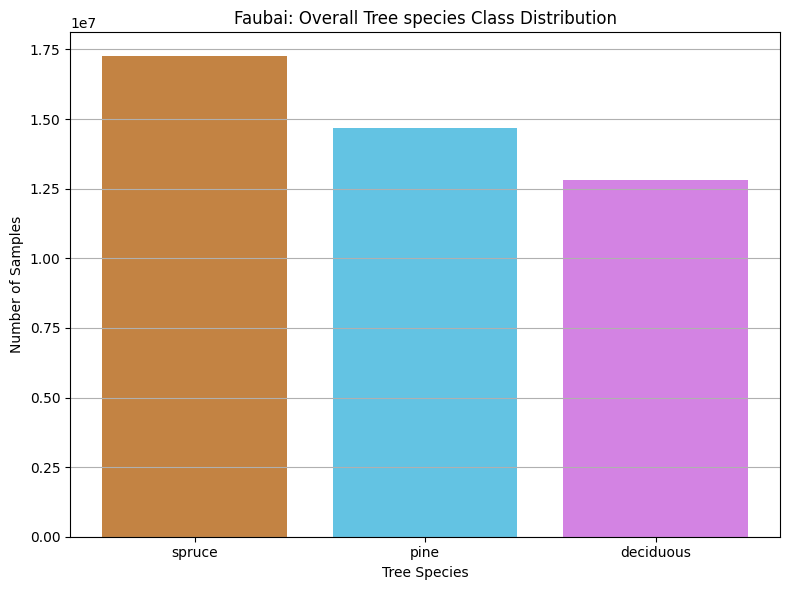

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt



# Focus only on the relevant tree species
species = ['spruce', 'pine', 'deciduous']

# Sum counts across the full dataset
total_counts = df_excel[species].sum()

# Plotting
plt.figure(figsize=(8,6))
plt.bar(total_counts.index, total_counts.values, color=[(180/255, 100/255, 20/255, 0.8), (60/255, 180/255, 220/255, 0.8), (200/255, 100/255, 220/255, 0.8)])
plt.title('Faubai: Overall Tree species Class Distribution')
plt.xlabel('Tree Species')
plt.ylabel('Number of Samples')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Mean and Std for Normalization

In [ ]:
def compute_bandwise_norm_streaming(chunk_dir, prefixes="train", num_threads=8):
    if isinstance(prefixes, str):
        prefixes = [prefixes]

    # Collect all chunk paths
    chunk_paths = []
    for prefix in prefixes:
        chunk_paths.extend(glob.glob(os.path.join(chunk_dir, f"{prefix}_chunk_*.pt")))

    # Stats accumulators
    total_sum = None
    total_sum_sq = None
    total_pixels = 0

    def process_chunk(path):
        chunk = torch.load(path, map_location='cpu')
        X = chunk['X']  # (N, Bands, H, W)
        N, C, H, W = X.shape
        X_flat = X.view(N, C, -1)
        return {
            "sum": X_flat.sum(dim=(0, 2)),
            "sum_sq": (X_flat ** 2).sum(dim=(0, 2)),
            "pixels": N * H * W
        }

    print(f"Processing {len(chunk_paths)} chunks with {num_threads} threads...")
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        for result in tqdm(executor.map(process_chunk, chunk_paths), total=len(chunk_paths), desc="Computing stats"):
            sum_, sum_sq_, pixels = result["sum"], result["sum_sq"], result["pixels"]
            if total_sum is None:
                total_sum = sum_
                total_sum_sq = sum_sq_
            else:
                total_sum += sum_
                total_sum_sq += sum_sq_
            total_pixels += pixels

    band_means = total_sum / total_pixels
    band_vars = (total_sum_sq / total_pixels) - (band_means ** 2)
    band_stds = torch.sqrt(band_vars)

    print("Done computing normalization stats.")
    return band_means, band_stds

In [ ]:
# band_means, band_stds = compute_bandwise_norm_streaming(save_dir_chunks, prefixes="train")

In [ ]:
# torch.save({'band_means': band_means, 'band_stds': band_stds}, '/home/salyken/PRISMA/PRISMA_data/PRISMA_dataset_processed/mean_std_71.pt')

In [ ]:
# Load from file
stats = torch.load('/home/salyken/PRISMA/PRISMA_data/PRISMA_dataset_processed/mean_std/mean_std_71.pt')

# Access tensors
band_means = stats['band_means']
band_stds = stats['band_stds']

In [ ]:
# Check shape
band_stds.shape

### Loading Dataset from Preprocessed in the Faubai_preprocessing.ipynb notebook

In [ ]:
class ChunkedDataset(Dataset):
    def __init__(self, chunk_dir, prefix="train", band_means=None, band_stds=None, augment=False, preload_all=False, clip_bands=False):
        self.chunk_paths = sorted([
            os.path.join(chunk_dir, f)
            for f in os.listdir(chunk_dir)
            if f.startswith(prefix) and f.endswith('.pt')
        ])
        self.clip_bands = clip_bands
        self.index_map = []
        if self.clip_bands:
            # Keep only the last 47 bands (HYPSO range)
            self.band_means = band_means[-47:].float() if band_means is not None else None
            self.band_stds = band_stds[-47:].float() if band_stds is not None else None
        else:
            self.band_means = band_means.float() if band_means is not None else None
            self.band_stds = band_stds.float() if band_stds is not None else None
        self.augment = augment
        self.preload_all = preload_all


        # Sorted from longest to shortest (already known)
        self.keep_indices = torch.tensor([
            16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
            26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
            36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
            46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
            56, 57, 58, 59, 60, 61, 62
        ])  # Corresponding to λ ≤ 802 nm

        self.full_data = []
        self.chunk_cache = {}

        for idx, path in enumerate(tqdm(self.chunk_paths, desc=f"Indexing {prefix} chunks")):
            data = torch.load(path, map_location='cpu')
            n = len(data['y'])
            self.index_map.extend([(idx, i) for i in range(n)])
            if self.preload_all:
                X = data['X'][:, self.keep_indices] if self.clip_bands else data['X']
                self.full_data.append((X.contiguous(), data['y'].contiguous()))

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        chunk_idx, sample_idx = self.index_map[idx]

        if self.preload_all:
            X, y = self.full_data[chunk_idx]
        else:
            if chunk_idx not in self.chunk_cache:
                self.chunk_cache.clear()
                data = torch.load(self.chunk_paths[chunk_idx], map_location='cpu')
                X = data['X'][:, self.keep_indices] if self.clip_bands else data['X']
                self.chunk_cache[chunk_idx] = (X, data['y'])
            X, y = self.chunk_cache[chunk_idx]

        sample = X[sample_idx]
        label = y[sample_idx]

        if self.band_means is not None and self.band_stds is not None:
            sample = (sample - self.band_means[:, None, None]) / (self.band_stds[:, None, None] + 1e-6)

        if self.augment:
            sample = self.apply_augmentations(sample)

        return sample.contiguous(), label

    def apply_augmentations(self, x):
        if torch.rand(1).item() < 0.5:
            x = torch.flip(x, dims=[2])
        if torch.rand(1).item() < 0.5:
            x = torch.rot90(x, k=1, dims=[1, 2])
        if torch.rand(1).item() < 0.5:
            x = x + torch.randn_like(x) * 0.01
        return x


In [ ]:
val_dataset = ChunkedDataset(
    chunk_dir=save_dir_chunks,
    prefix="val",
    band_means=band_means,
    band_stds=band_stds,
    augment=False,
    preload_all=True,
    clip_bands=True
)

In [ ]:
train_dataset = ChunkedDataset(
    chunk_dir=save_dir_chunks,
    prefix="train",
    band_means=band_means,
    band_stds=band_stds,
    augment=True,
    preload_all=True,  # avoids torch.load during training
    clip_bands=True
)

In [ ]:
# Fetch one sample
patch, label = train_dataset[0]  # First patch

# Print info
print("Patch shape:", patch.shape)
print("Label:", label)


Patch shape: torch.Size([47, 71, 71])
Label: tensor(0)


### Traning Loop

In [ ]:

# EarlyStopping Helper
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


def train_one_epoch(model, dataloader, optimizer, criterion, device, scaler):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    loop = tqdm(dataloader, desc="Training", leave=False, mininterval=1.0)

    for inputs, targets in loop:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        with autocast(device_type='cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        correct += preds.eq(targets).sum().item()
        total += targets.size(0)

        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc



def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    loop = tqdm(dataloader, desc="Validating", leave=False, mininterval=1.0)

    with torch.no_grad():
        for inputs, targets in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            with autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)

            loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc



def train_model(model, train_loader, val_loader, num_epochs, device, save_path, resume=True):
    os.makedirs(save_path, exist_ok=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    scaler = GradScaler()
    # early_stopping = EarlyStopping(patience=7)

    best_val_acc = float('-inf')
    best_val_loss = float('inf')
    start_epoch = 0

    # Checkpoint paths
    last_epoch_path = os.path.join(save_path, "checkpoint.pth")
    best_acc_path = os.path.join(save_path, "best_val_acc.pth")
    best_loss_path = os.path.join(save_path, "best_val_loss.pth")
    print('save path: ', last_epoch_path)


    # WITHOUT DATAPARALLELL
    # Resume training

    # if resume and os.path.exists(last_epoch_path):
    #     print("🔄 Resuming from last checkpoint...")
    #     checkpoint = torch.load(last_epoch_path, map_location=device)
    #     model.load_state_dict(checkpoint['model_state_dict'])
    #     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #     start_epoch = checkpoint.get('epoch', 0) + 1
    #     best_val_acc = checkpoint.get('best_val_acc', best_val_acc)
    #     best_val_loss = checkpoint.get('best_val_loss', best_val_loss)
    #     print(f"✅ Resumed from epoch {start_epoch}")

    # WITH DATAPRALLELL, IF NOT USE BLOCK OVER
    # Resume training
    if resume and os.path.exists(last_epoch_path):
        print("🔄 Resuming from last checkpoint...")
        checkpoint = torch.load(last_epoch_path, map_location=device)
        print("Saved epoch:", checkpoint['epoch'])
        raw_state_dict = checkpoint['model_state_dict']
        
        # Strip 'module.' if it exists
        clean_state_dict = {
            k.replace("module.", ""): v for k, v in raw_state_dict.items()
        }

        model.load_state_dict(clean_state_dict, strict=False)
        print("✅ Loaded model weights")

        optimizer_state = checkpoint['optimizer_state_dict']
        start_epoch = checkpoint.get('epoch', 0)
        best_val_acc = checkpoint.get('best_val_acc', best_val_acc)
        best_val_loss = checkpoint.get('best_val_loss', best_val_loss)
        print(f"✅ Resumed from epoch {start_epoch}, with best val acc and loss: {best_val_acc}, {best_val_loss}")
    else:
        optimizer_state = None

    # Wrap in DataParallel
    if torch.cuda.device_count() > 1:
        print(f"🖥️ Using {torch.cuda.device_count()} GPUs with DataParallel")
        model = nn.DataParallel(model)

    model = model.to(device)

    # Restore optimizer if resumed
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    if optimizer_state is not None:
        optimizer.load_state_dict(optimizer_state)


    for epoch in range(start_epoch + 1, num_epochs):
        train_loss, train_acc= train_one_epoch(model, train_loader, optimizer, criterion, device, scaler)
        scheduler.step()
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        print(f"Epoch [{epoch}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        # Save latest checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'best_val_loss': best_val_loss
        }, last_epoch_path)
        print(f"💾 Saving checkpoint at epoch {epoch}")

        # Save best accuracy model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc
            }, best_acc_path)
            print("✅ Best accuracy model saved.")

        # Save best loss model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss
            }, best_loss_path)
            print("✅ Best loss model saved.")

        # Early stopping
        # early_stopping(val_loss)
        # if early_stopping.early_stop:
        #     print("⏹️ Early stopping triggered.")
        #     break

    print("🎉 Training complete!")



### Train models

In [ ]:

model = ImprovedHybrid3D2DCNN_v2(in_bands=47, num_classes=3)

In [ ]:
model = HyperspectralTransferCNN(backbone_type='custom')

In [ ]:
model = VGG16WithAttention(input_bands=63, num_classes=3)

In [ ]:
model = VGG16WithCBAM(num_classes=3, in_channels=47)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=256, num_workers=8, shuffle=True, pin_memory = True, persistent_workers=False)
val_loader = DataLoader(val_dataset, batch_size=256, num_workers=8, shuffle=False, pin_memory = True, persistent_workers=False)


train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=51,
    device=torch.device("cuda"),
    save_path="/home/salyken/PRISMA/PRISMA_data/PRISMA_dataset_processed/model/2D",
    resume=True
)
